# Credit Card Fraud Detection - Kaggle

The dataset id downloaded from Kaggle (https://www.kaggle.com/dalpozz/creditcardfraud), which contains data about credit card transactions that occurred during a period of two days, with 492 fraud cases out of 284807 transactions. 

The label are extremely unbalanced. We are going to use autoencoder to detect the fraud cases.

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras import regularizers

Using TensorFlow backend.


#### 1. Load date

In [4]:
df = pd.DataFrame.from_csv('creditcard.csv')
df.reset_index(drop = False, inplace = True)

#### 2. Data exploration

In [5]:
df.shape

(284807, 31)

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# no missing values, good!
df.isnull().sum().sum()

0

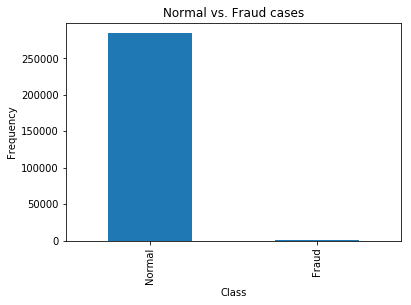

In [8]:
# label counting
count_class = pd.value_counts(df.Class, sort = True)
count_class.plot(kind = 'bar')
plt.title('Normal vs. Fraud cases')
plt.xticks(range(2), ['Normal', 'Fraud'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

the plots shows we have extremely inbalanced labels. let's dig more into these two classes

In [9]:
frauds = df.loc[df.Class == 1]
normal = df.loc[df.Class == 0]
print (frauds.shape, normal.shape)

(492, 31) (284315, 31)


how different of the amount of mondy used in these two different classes?

In [10]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [11]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

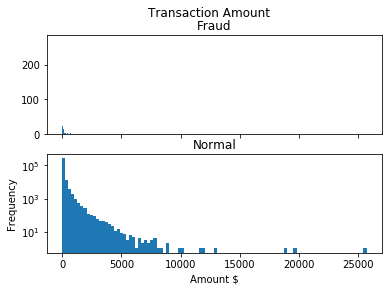

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
fig.suptitle('Transaction Amount')

ax1.hist(frauds.Amount, bins = 100)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = 100)
ax2.set_title('Normal')

plt.xlabel('Amount $')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

we already know their distribution is so different, how about their happening time? Is there certern period that fraud cases happenning more frequent?

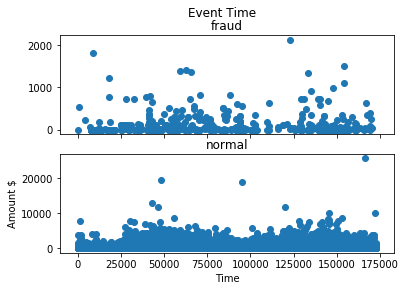

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.suptitle('Event Time')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('normal')

plt.xlabel('Time')
plt.ylabel('Amount $')
plt.show()

It seems that the event time doesn't really matter

#### 3. Autoencoders

Autoencoder Neural Network tries to learn to approxiamte the following identity function: Fw,b(x) ~ x

It might sounds to trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find stuction.  This can be done by limiting the nmber of hidden units.

The more detailed explanation can see (https://blog.keras.io/building-autoencoders-in-keras.html)

Here's a visual representation of what an Autoencoder might learn

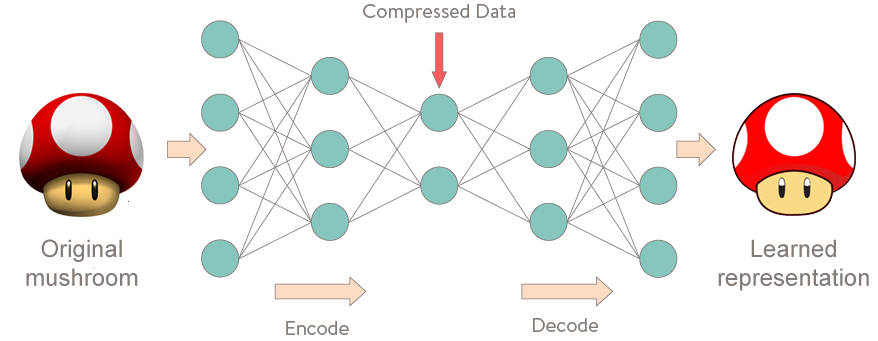

In [15]:
from IPython.display import Image
Image(filename = 'auto.png')

We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. A useful tutorial vedio for Autoencoder can see (https://youtu.be/FzS3tMl4Nsc)

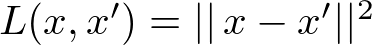

In [16]:
# traditional 
Image(filename = 'formular.png')

#### 4. Data Preparation

First, lets prepare the dataset.  data is split into train, validation and test (don't forget to stratify data based on label), and use MinMaxScaler on the Amount. The scalers moves all values between 0 and 1.

In [337]:
from sklearn.model_selection import train_test_split
data = df.drop(['Time'], axis = 1)
col_name = list(set(list(data)) - set(['Class']))
train, test = train_test_split(data, test_size = 0.2, random_state = 5632145, shuffle = True, stratify = df.Class)
X_orig, y_orig = train[col_name], train['Class']
train = train.loc[train.Class == 0]
train, val = train_test_split(train, test_size = 0.2, random_state = 5632145, shuffle = True, stratify = train.Class)
X_train, y_train, X_val, y_val = train[col_name], train['Class'], val[col_name], val['Class']
X_test, y_test = test[col_name], test['Class']

In [338]:
from sklearn.preprocessing import StandardScaler
mm_scaler = StandardScaler()
mm_scaler.fit(X_train)
X_train = mm_scaler.transform(X_train)
X_val = mm_scaler.transform(X_val)
X_test = mm_scaler.transform(X_test)
X_orig = mm_scaler.transform(X_orig)

In [339]:
X_test.shape

(56962, 29)

#### 5. Model Build

The model uses fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are our encoder, last two go for the decoder. Addtionally, l1 regularizationi wil be used during training

In [340]:
encoding_dim = 14
input_dim = X_train.shape[1]
input_layer = Input(shape = (input_dim,))
encoded = Dense(encoding_dim, activation='tanh', activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoded = Dense(int(encoding_dim /2), activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='tanh')(encoded)
decoded = Dense(input_dim, activation = 'relu')(decoded)
autoencoder = Model(inputs = input_layer, outputs=decoded)
# encoder = Model(input_layer, encoded)
# encoded_input = Input(shape = (encoding_dim, ))
# decoder_layer = autoencode.layers[-1]
# decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss = 'mean_squared_error')

Training..........................

In [341]:

checkpointer = ModelCheckpoint(filepath='model.h5', verbose = 0, save_best_only=True)
Early_stop = EarlyStopping(monitor='val_loss', patience = 2, verbose = 1)
history = autoencoder.fit(X_train, X_train, epochs = 100, batch_size = 500, shuffle=True, validation_data = (X_val,X_val),callbacks=[checkpointer, Early_stop]).history

Train on 181960 samples, validate on 45491 samples
Epoch 1/100
181960/181960 [==============================] - 2s 13us/step - loss: 0.9348 - val_loss: 0.8639
Epoch 2/100
181960/181960 [==============================] - ETA: 0s - loss: 0.822 - 1s 6us/step - loss: 0.8213 - val_loss: 0.8127
Epoch 3/100
181960/181960 [==============================] - 1s 6us/step - loss: 0.7886 - val_loss: 0.7906
Epoch 4/100
181960/181960 [==============================] - 1s 7us/step - loss: 0.7728 - val_loss: 0.7791
Epoch 5/100
181960/181960 [==============================] - 1s 7us/step - loss: 0.7602 - val_loss: 0.7664
Epoch 6/100
181960/181960 [==============================] - 1s 7us/step - loss: 0.7523 - val_loss: 0.7604
Epoch 7/100
181960/181960 [==============================] - 1s 7us/step - loss: 0.7463 - val_loss: 0.7549
Epoch 8/100
181960/181960 [==============================] - 1s 7us/step - loss: 0.7420 - val_loss: 0.7509
Epoch 9/100
181960/181960 [==============================] - 1s 7us/

#### 6. Evaluation

In [342]:
autodecoder = load_model('model.h5')

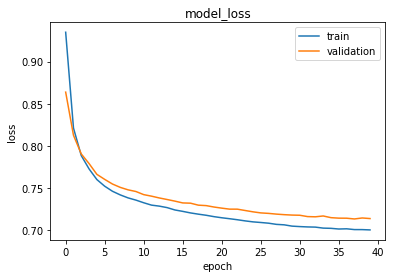

In [343]:
plt.plot(history['loss'], label = 'train')
plt.plot(history['val_loss'], label = 'validation')
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

The reconstruction error on our training andtest data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution

In [344]:
sum(y_orig)*1. / y_orig.shape[0]

0.0017292457591783889

In [345]:
prediction = autoencoder.predict(X_orig)
mse = np.mean(np.power(X_orig - prediction, 2), axis = 1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_orig})

In [346]:
error_df.describe()

,reconstruction_error,true_class
count,227845.000000,227845.000000
mean,0.739980,0.001729
std,4.308470,0.041548
min,0.044907,0.000000
25%,0.280188,0.000000
50%,0.429362,0.000000
75%,0.663205,0.000000
max,1421.717904,1.000000


We compare the error between normal and fraud cases, it is obviously that fraud cases have far more error than the normal cases

let's select a threshold based on the error of normal cases

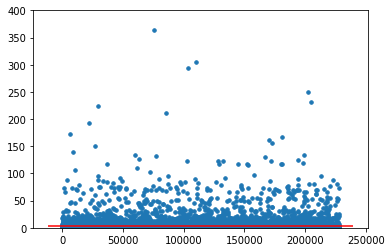

In [361]:
fig, ax = plt.subplots()
ax.plot(range(1, error_df.shape[0] + 1), list(error_df.reconstruction_error), marker = 'o', ms = 3.5, linestyle = '')
threshold = error_df.reconstruction_error.quantile(0.985)
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors = 'red', zorder = 100, label = 'Threshold')
plt.ylim(0, 400)
plt.show()

In [362]:
print (threshold)

3.7189009556149997


In [363]:
prediction_test = autoencoder.predict(X_test)
mse_test = np.mean(np.power(X_test - prediction_test, 2), axis = 1)

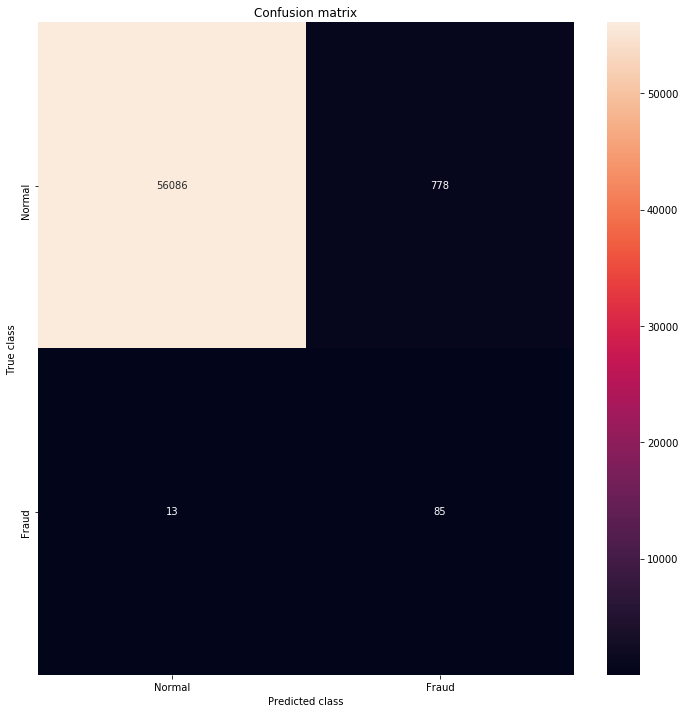

In [364]:
from sklearn.metrics import confusion_matrix
y_pred = [1 if e > threshold else 0 for e in mse_test]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
labels = ['Normal', 'Fraud']
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

#### Conclusion

In this project, we have created a simple Autoencoder for fraud detction.It may be kind of strange initially, why do you use the unsupervised learning to solve the supervised problem. After the experiments, it is proved that works. Think about it, we gave a lot of one-class examples to a model and it learned how to discrimate whether or not new examples belong to that same class. Is it really cool? The process is magical. The model doesn't know waht the original label looks like. 